# Data Preperation

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.stats import randint
from scipy.stats import uniform

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score,
                             f1_score,fbeta_score,roc_auc_score, roc_curve, auc)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance

import joblib
import sys

sys.path.append('..')

from src.visualizations import plot_kdes
from src.visualizations import plot_boxplots
from src.model_evaluations import (evaluate,plot_roc,plot_feature_importances,plot_conf_matrix,
                                   impurity_importance_plot,permutation_importance_plot)

In [2]:
# Load the processed data
df = pd.read_csv('..\data\processed\cardio_processed.csv')


## Feature Engineering

Let's intorduce new features by combining the already existing features:

Start with the BMI (Body Mass Index) calculated by BMI = weight(kg) / (height(m))^2

In [3]:
# BMI = weight(kg) / (height(m))^2
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)

Introduce Pulse Pressure:

In [4]:
# Pulse Pressure (important cardiac indicator)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']

Introduce Mean Arterial Pressure (MAP), calculated by map = (ap_hi) + 2 * (ap_lo) / 3

In [5]:
# Mean Arterial Pressure (MAP)
df['map'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3

Introduce Total Number of risk Factors:

In [6]:
# Total number of risk factors
df['total_risk_factors'] = (
    df['smoke'] + 
    df['alco'] + 
    (df['cholesterol'] > 1).astype(int) + 
    (df['gluc'] > 1).astype(int) + 
    (1 - df['active'])  # Inactive is a risk factor
)

Check the distributions of the engineered variables in order to determine how do scale them:

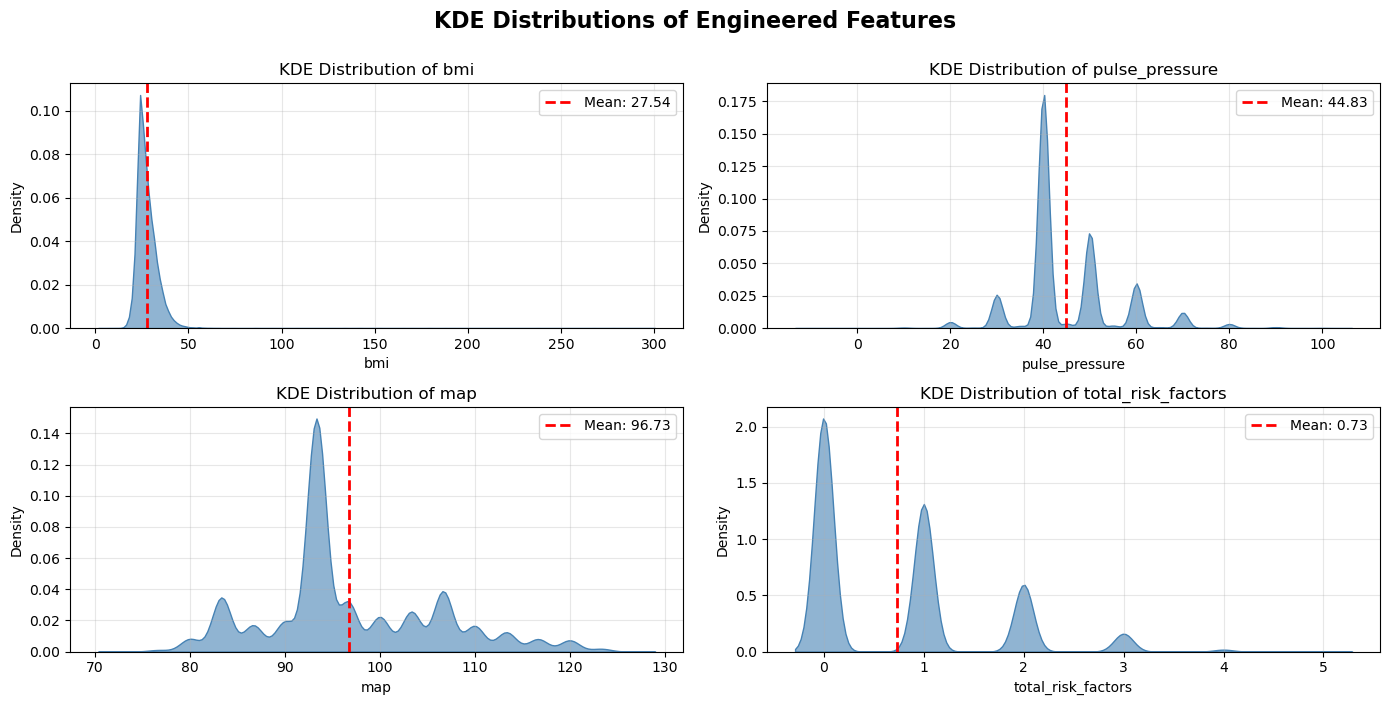

In [7]:
engineered_features = ['bmi','pulse_pressure','map','total_risk_factors']

plot_kdes(engineered_features,df,nrows=2,ncols = 2,figsize = (14,7),
          suptitle = 'KDE Distributions of Engineered Features')

BMI seems to be skewed to the right let's, check box plots for outliers:

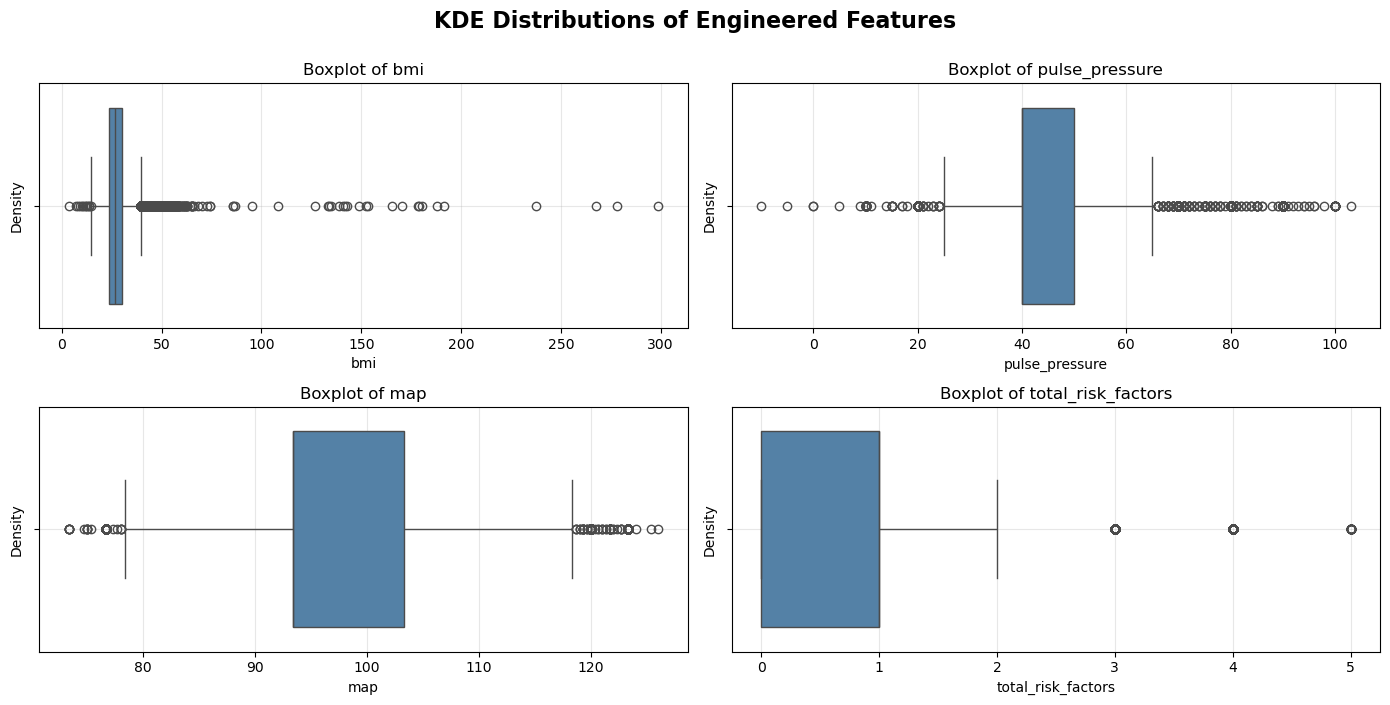

In [8]:
plot_boxplots(engineered_features,df,nrows=2,ncols = 2,figsize = (14,7),
          suptitle = 'KDE Distributions of Engineered Features')

Although BMI has extreme outliers, these ar erealisticly achievable mody mass indexes that indicate extreme obessity, therefore we can ignore it.

## Data Splitting

In [9]:
# Split the data into dependent and independent variables
X = df.drop(columns = 'cardio')
y = df['cardio']

In [10]:
# Split the data into train/test split (80/20% respectively) with stratification on the target variable
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify = y,shuffle = True,random_state = 42)

## Normalization/Standardization

For scaling of the features use the folowing strategy:

* height and weight - gaussian distributions, so the best strategy is standardizing.
* age, ap_hi, ap_lo, bmi, pulse_pressure, map - non-gaussian distribution, so use minmax scaler for these
* gender, cholesterol, gluc, total_risk_factors - ordinal attributes, so use minmax sclaer to get them in the 0 to 1 range
* smoke, alco, active - binary attributes, already in hte range of 0 to 1 so no need for scaling

In [11]:
minmax_scaler = MinMaxScaler()
standart_scaler = StandardScaler()

cols_to_minmax_scale = ['age','gender','ap_hi','ap_lo','cholesterol','gluc','bmi','pulse_pressure','map','total_risk_factors']
cols_to_standardize = ['height','weight']

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Fit the scalers on just the training data to avoid data leakage
minmax_scaler.fit(X_train[cols_to_minmax_scale])
standard_scaler.fit(X_train[cols_to_standardize])

# Tranform on training and test data
X_train[cols_to_minmax_scale] = minmax_scaler.transform(X_train[cols_to_minmax_scale])
X_test[cols_to_minmax_scale] = minmax_scaler.transform(X_test[cols_to_minmax_scale])

X_train[cols_to_standardize] = standard_scaler.transform(X_train[cols_to_standardize])
X_test[cols_to_standardize] = standard_scaler.transform(X_test[cols_to_standardize])

# Model Training

## Logistic Regression

Define the cross validation technque for hyperparameter tuning, in this case let's choose StratifiedKFold with 5 folds:

In [12]:
skf = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)

Train the logistic regression model using GridSearchCV to tune the following hyperparameters:

* C : Regularization penalty term - try [0.001, 0.01, 0.1, 1, 10]
* penalty : Regularization type - L1 regularization (Lasso) or L2 regularization (Ridge)
* solver : optimization algorithm - try liblinear and saga
* max_iter : maximum number of iterations - fixed on 500

I am going to be optimizing the Recall score, since we care more about false negatives and detecting the cardiovascular disease when it's actually there.

In [13]:
param_grid_log_reg = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"],
    "max_iter": [500]
}

log_reg = LogisticRegression(random_state=42)

grid_log_reg = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_log_reg,
    cv=skf,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

grid_log_reg.fit(X_train, y_train)

best_log_reg = grid_log_reg.best_estimator_

print(f"Best Hyperparameters for Logistic Regression: {grid_log_reg.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters for Logistic Regression: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}


In [14]:
y_prob_log_reg = best_log_reg.predict_proba(X_test)[:,1]

y_pred_log_reg = (y_prob_log_reg >= 0.5).astype(int)

print("=== Evaluation of the Logistic Regression Model ===")
evaluate(y_test,y_pred_log_reg)

=== Evaluation of the Logistic Regression Model ===
Accuracy: 0.7010309278350515
Precision: 0.7073996453329034
Recall: 0.6824261275272162
F1 Score: 0.6946885142088182


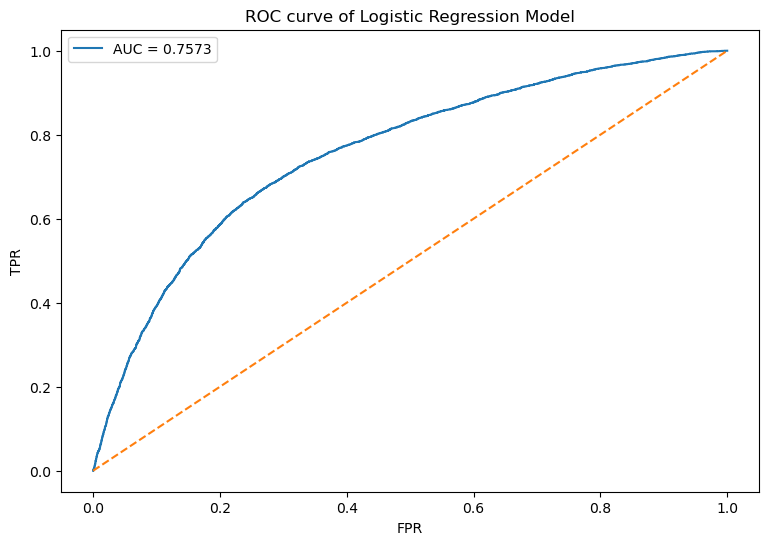

In [15]:
plot_roc(y_test,y_prob_log_reg,title = "ROC curve of Logistic Regression Model")

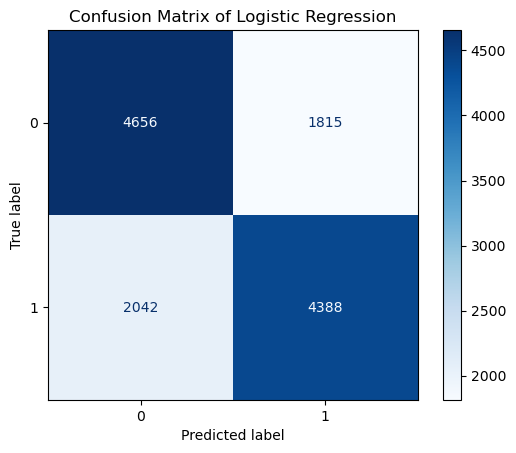

In [16]:
plot_conf_matrix(y_test, y_pred_log_reg, labels=[0, 1], title="Confusion Matrix of Logistic Regression")

We have 2042 cases of false negatives, which is we predicted does not have cardiovascular disease when the patient actually had one.

Visualize the feature importance of out best logistic regression model:

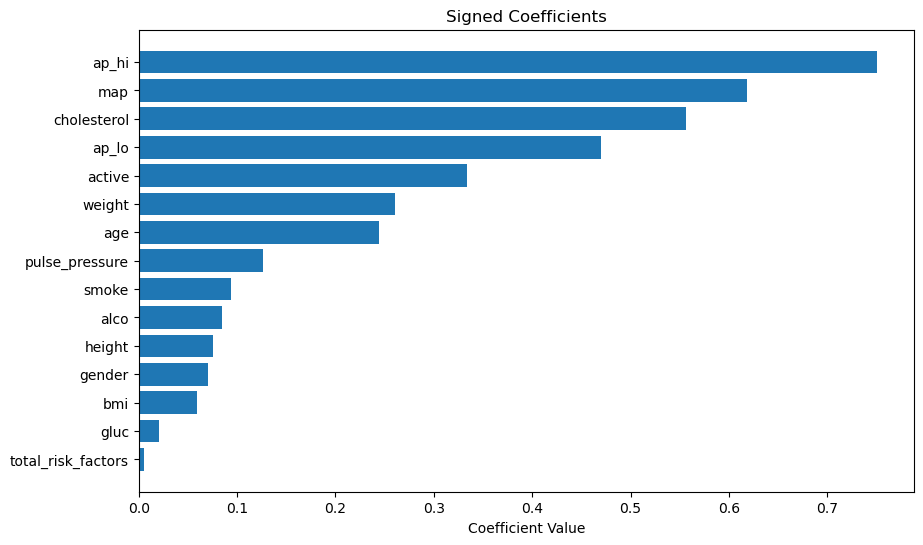

In [17]:
plot_feature_importances(best_log_reg,X_train)

As excpeted ap_hi turned out to be the most important feature. Tt seems, that one of our engineered features (MAP) turned out to be very helpful to the model.

## Decision Tree Classifier

For Hyperparameter tuning RandomizedSearch is a good choice for Tree-based models, since we are trying out some hyperparameters in numeric ranges.

In [18]:
params_dec_tree_clas = {
    "criterion": ["gini", "entropy", "log_loss"],
    "min_impurity_decrease": uniform(0.0, 0.05),
    "max_depth": [None, 5, 10, 20, 30, 40],
    "min_samples_split": randint(2, 30),
    "min_samples_leaf": randint(1, 20),
    "max_features": ["sqrt", "log2", None]
}

dec_tree_clas = DecisionTreeClassifier(random_state = 42)

search_dec_tree_clas = RandomizedSearchCV(
    dec_tree_clas,
    param_distributions=params_dec_tree_clas,
    n_iter=50,
    cv=skf,
    scoring="recall",
    random_state = 42,
    n_jobs=-1,
)

search_dec_tree_clas.fit(X_train, y_train)

best_dec_tree_clas = search_dec_tree_clas.best_estimator_

print(f"Hyperarameters of the best Decision Tree Classifier: \n{search_dec_tree_clas.best_params_}")

Hyperarameters of the best Decision Tree Classifier: 
{'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_impurity_decrease': np.float64(0.0010292247147901223), 'min_samples_leaf': 2, 'min_samples_split': 25}


Let's plot the resulted tree structure:

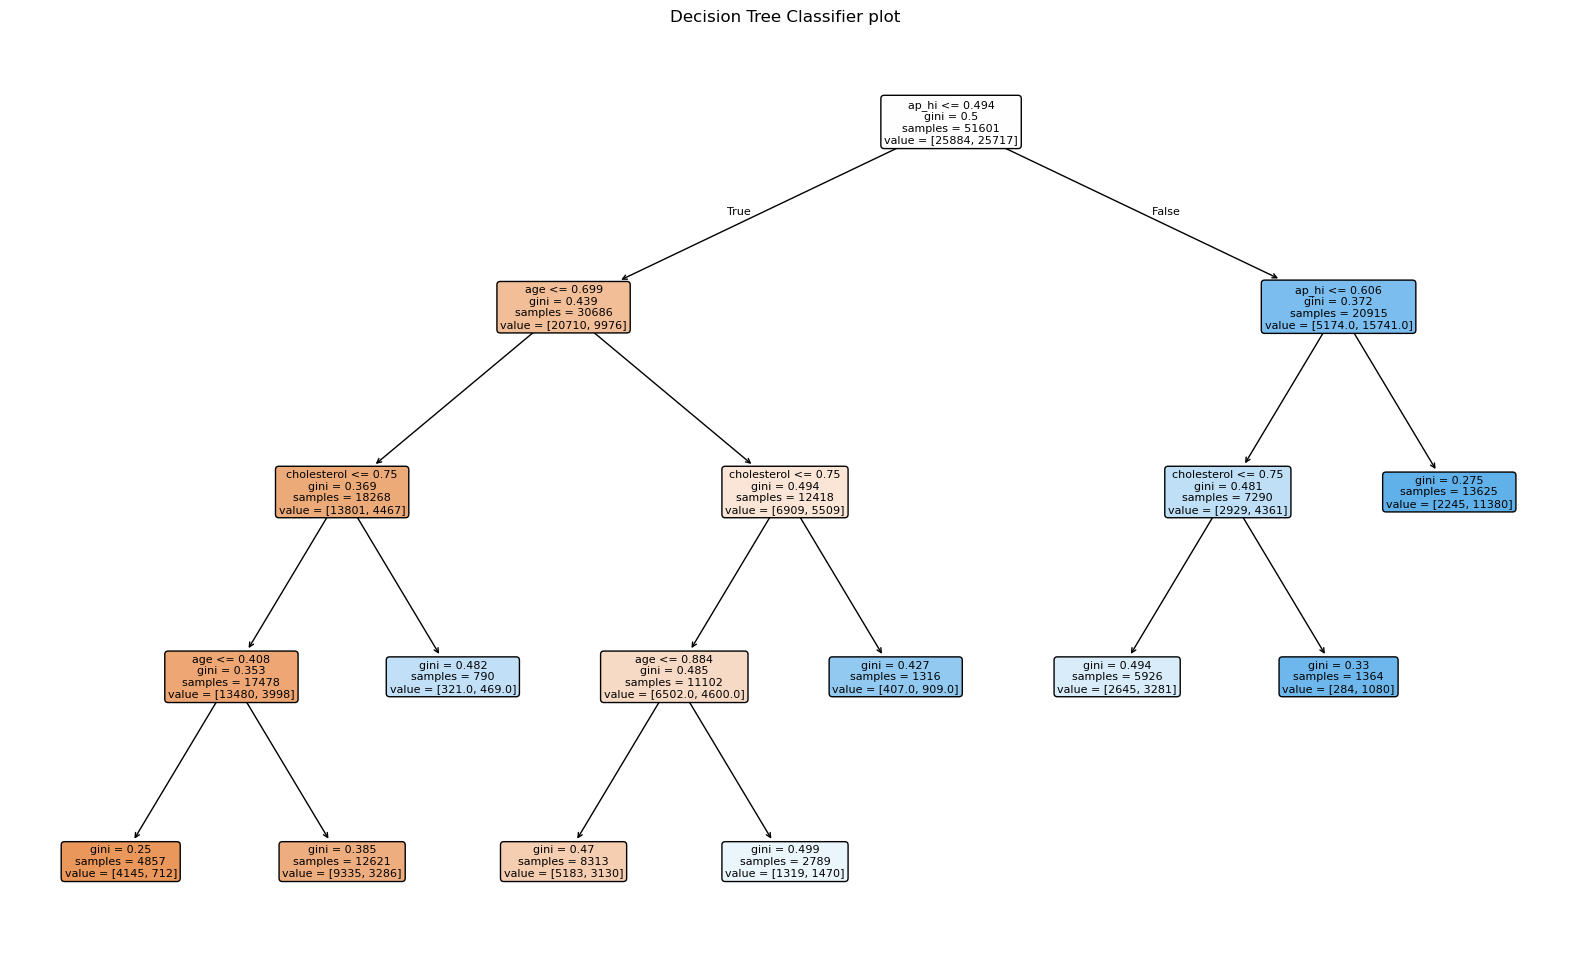

In [19]:
plt.figure(figsize=(20, 12))
plot_tree(
    best_dec_tree_clas,
    feature_names=X_train.columns,
    max_depth = None,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree Classifier plot")
plt.show()

Very simple deicison tree, easily intepretable with only 8 leaves:

In [20]:
y_pred_dec_tree_clas = best_dec_tree_clas.predict(X_test)

print(f"==Evaluation of the Decision Tree Classifier==")
evaluate(y_test,y_pred_dec_tree_clas)

==Evaluation of the Decision Tree Classifier==
Accuracy: 0.7283156344469421
Precision: 0.7257989810097267
Recall: 0.7311041990668741
F1 Score: 0.72844193073526


Way better results than what Logistic Regression produced with recall being 0.73 (logistic regression had 0.68).

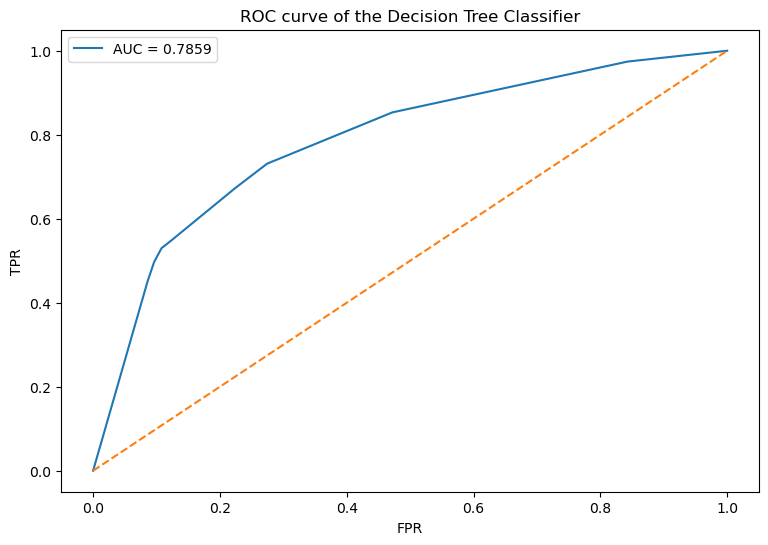

In [21]:
y_prob_dec_tree_clas = best_dec_tree_clas.predict_proba(X_test)[:, 1]

plot_roc(y_test,y_prob_dec_tree_clas,title = 'ROC curve of the Decision Tree Classifier')

Even the ROC-AUC score is much better, meaning Decision Tree dominates Logistic Regression's performance by far. The ROC curve looks angular, since each angle represents a leaf on the decision tree. 

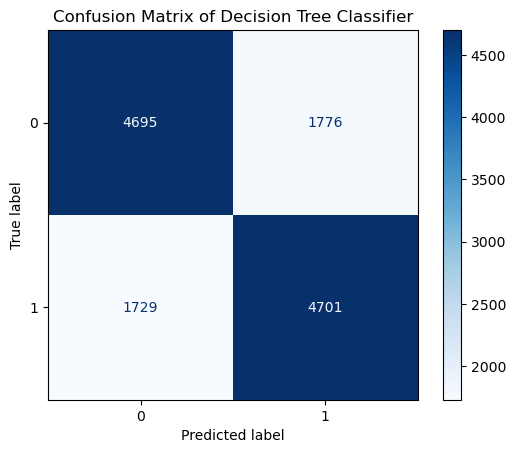

In [22]:
plot_conf_matrix(y_test, y_pred_dec_tree_clas, labels=[0, 1], title="Confusion Matrix of Decision Tree Classifier")

1729 cases of false negatives, which is much less than what the logistic regression produced.

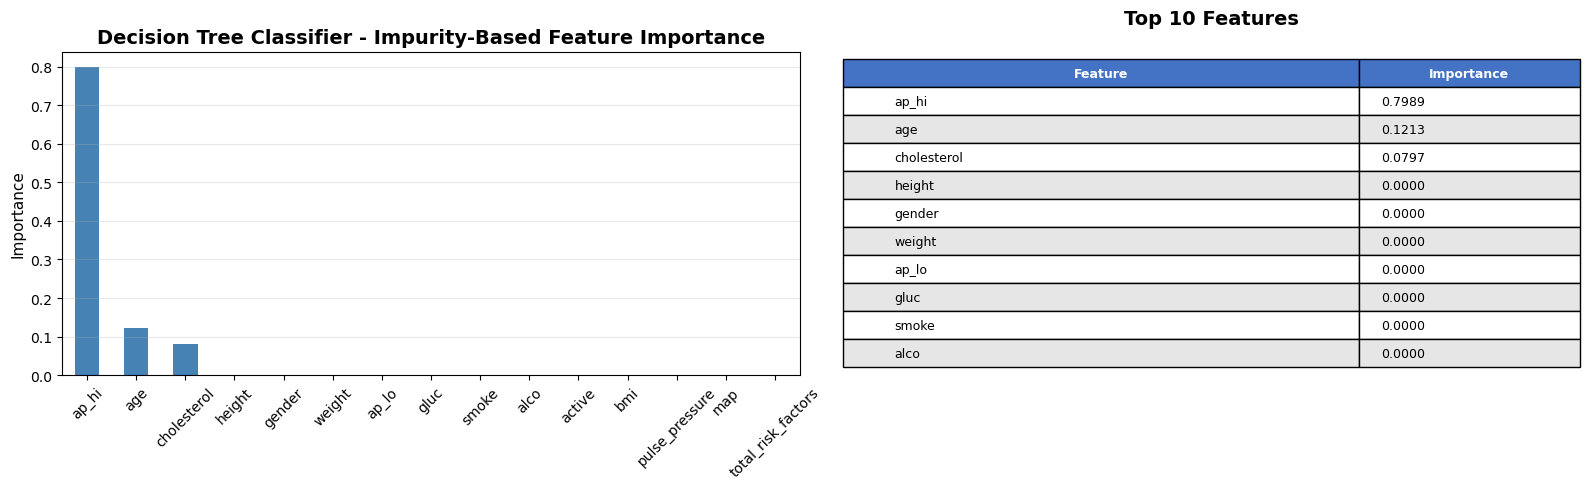

In [23]:
impurity_importance_plot(best_dec_tree_clas, X_train, title="Decision Tree Classifier")

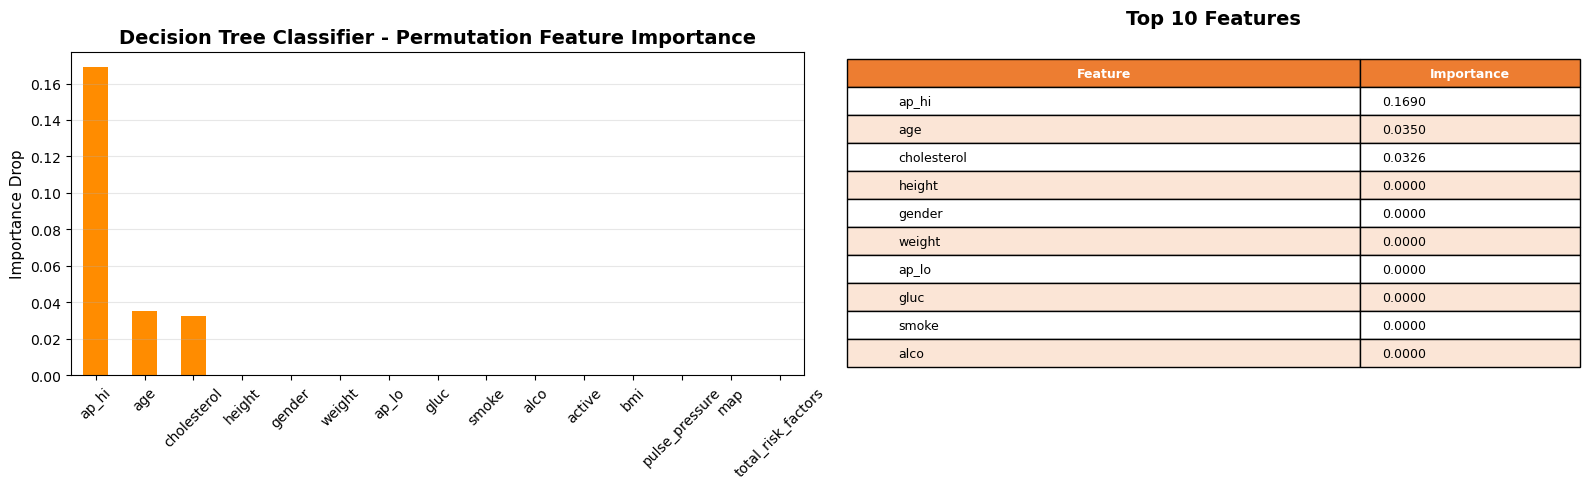

In [24]:
permutation_importance_plot(best_dec_tree_clas, X_train, y_train, X_test, y_test, title="Decision Tree Classifier")

Since, the only features that were used for splitting were ap_hi, age and cholesterol we got 0 importances for other features. ap_hi turned out to be the most important feature for the Decision Tree Classifier as well.

## XGBoost Classifier

Let's train an XGBoost Classifier with almost the same hyperparameter tuning technqieu as we used for Deicison Tree model:

In [25]:
params_xgb_clas = {
    "n_estimators": randint(30, 150),
    "max_depth": randint(2, 5),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 5),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 1),
}

search_xgb_clas = RandomizedSearchCV(
    XGBClassifier(random_state=42, tree_method="hist", use_label_encoder=False,eval_metric="logloss"),
    param_distributions=params_xgb_clas,
    n_iter=50,
    cv=skf,
    scoring="recall",
    random_state=42,
    n_jobs=-1
)

search_xgb_clas.fit(X_train, y_train)

best_xgb_clas = search_xgb_clas.best_estimator_

print(f"Hyperparameters of the best XGBoost Classifier: \n{search_xgb_clas.best_params_}")

c:\Users\User\anaconda3\envs\Env1\lib\site-packages\xgboost\training.py:199: UserWarning: [22:19:14] WARNING: C:\miniconda3\conda-bld\xgboost-split_1764761400759\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Hyperparameters of the best XGBoost Classifier: 
{'colsample_bytree': np.float64(0.8108963368184213), 'gamma': np.float64(1.2107996913871295), 'learning_rate': np.float64(0.25094192691396877), 'max_depth': 2, 'n_estimators': 145, 'reg_alpha': np.float64(0.983423140894843), 'reg_lambda': np.float64(0.39882444244455306), 'subsample': np.float64(0.9449295619658151)}


In [26]:
y_pred_xgb_clas = best_xgb_clas.predict(X_test)

print(f"==Evaluation of the XGBoost Classifier==")
evaluate(y_test,y_pred_xgb_clas)

==Evaluation of the XGBoost Classifier==
Accuracy: 0.7359119448104798
Precision: 0.755191625865271
Recall: 0.6956454121306377
F1 Score: 0.7241965514449931


Surprisingly XGBoost classifier seemed to have performed worse than the Decision Tree classifier.

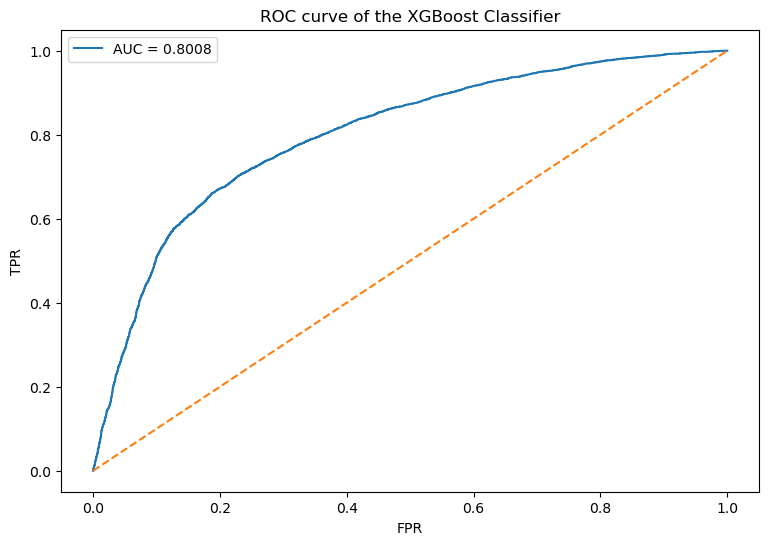

In [27]:
y_prob_xgb_clas = best_xgb_clas.predict_proba(X_test)[:, 1]

plot_roc(y_test,y_prob_xgb_clas,title = 'ROC curve of the XGBoost Classifier')

On the other hand XGBoost seemed to have imporved the ROC-AUC score with 0.80 (Decision Tre had 0.78).

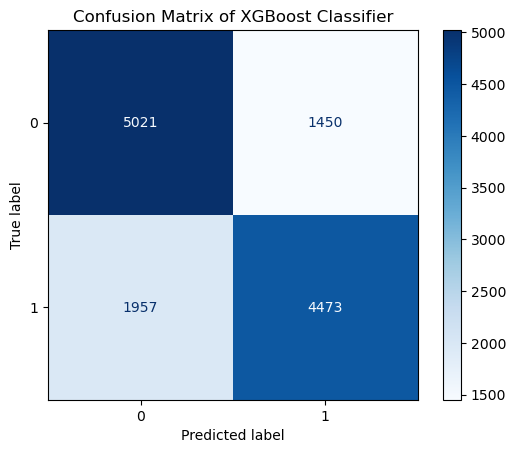

In [28]:
plot_conf_matrix(y_test, y_pred_xgb_clas, labels=[0, 1], title="Confusion Matrix of XGBoost Classifier")

1957 false negative cases, which is better than logistic regression but worse than decision tree classifier.

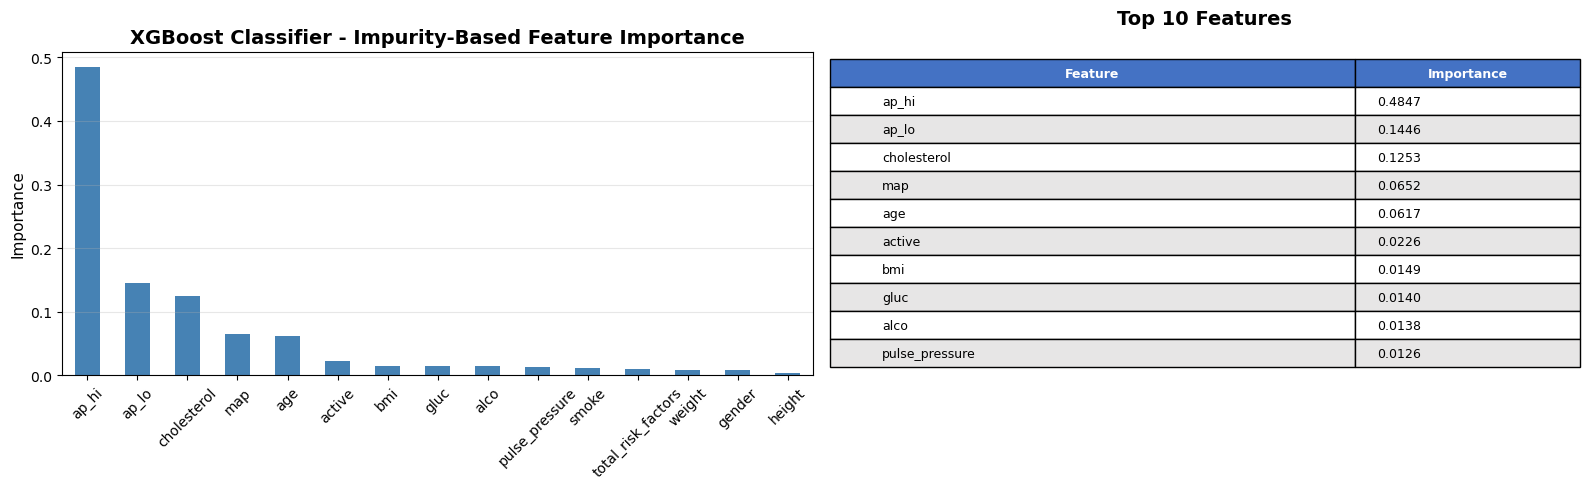

In [29]:
impurity_importance_plot(best_xgb_clas, X_train, title="XGBoost Classifier")

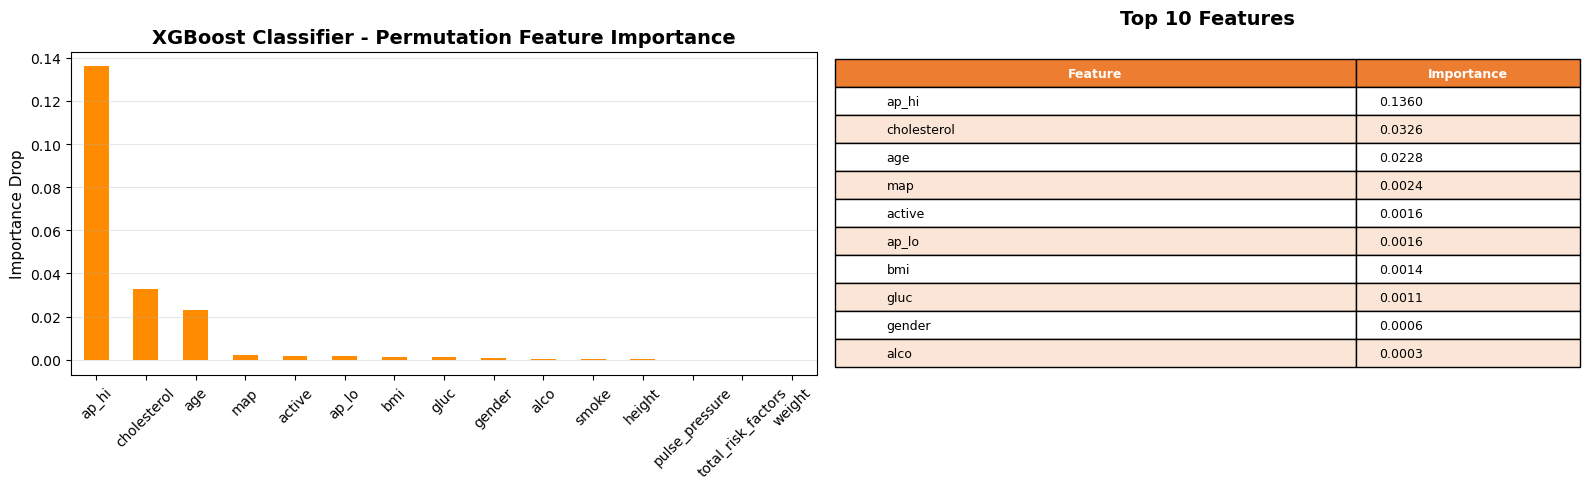

In [30]:
permutation_importance_plot(best_xgb_clas, X_train, y_train, X_test, y_test, title="XGBoost Classifier")

XGBoost used more feature for splitting, rather than Decision Tree, maybe this overcomplication is why it performed worse and maybe the Decision Tree was best because of the simple approach.

## Naive Bayes

In [31]:
nb = GaussianNB()

param_grid_nb = {
    "var_smoothing": np.logspace(-12, 0, 20)
}

grid_nb = GridSearchCV(
    nb,
    param_grid_nb,
    cv=skf,
    scoring="recall"
)

grid_nb.fit(X_train, y_train)

best_nb = grid_nb.best_estimator_

print(f"Best Hyperparameters for Naive Bayes: {grid_nb.best_params_}")

Best Hyperparameters for Naive Bayes: {'var_smoothing': np.float64(1e-12)}


In [32]:
y_prob_nb = best_nb.predict_proba(X_test)[:,1]

y_pred_nb = best_nb.predict(X_test)

print("=== Evaluation of the Naive Bayse Model===")
evaluate(y_test,y_pred_nb)

=== Evaluation of the Naive Bayse Model===
Accuracy: 0.721882024649252
Precision: 0.7745363214837713
Recall: 0.6234836702954899
F1 Score: 0.6908495605721179


Worst performance for Recall we've seen, but the best performance for precision.

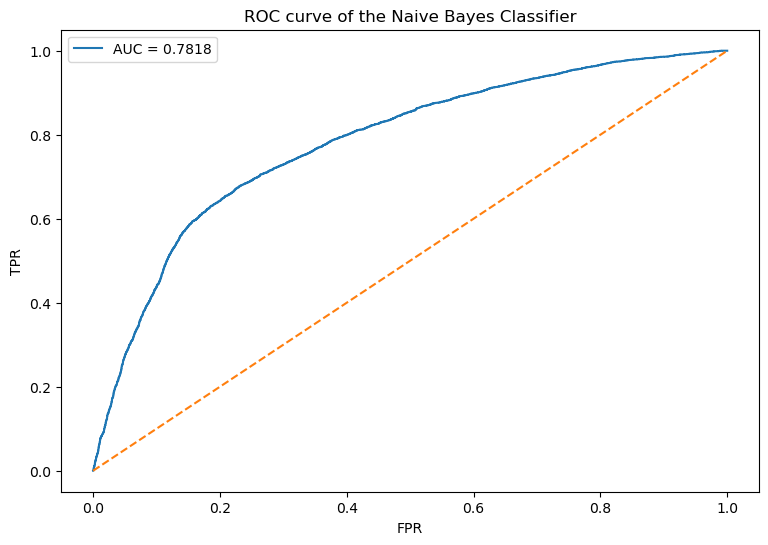

In [33]:
plot_roc(y_test,y_prob_nb,title = 'ROC curve of the Naive Bayes Classifier')

Better ROC-AUC score than Logistic Regression.

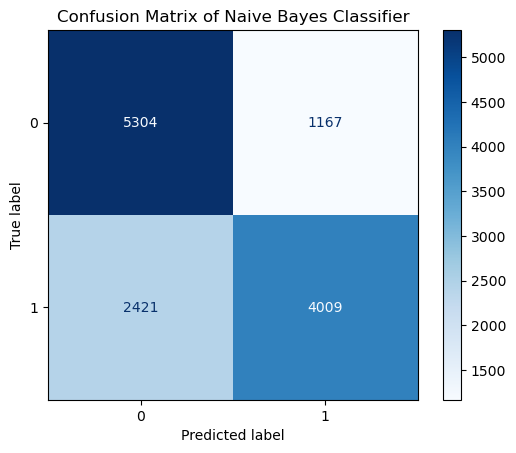

In [34]:
plot_conf_matrix(y_test, y_pred_nb, labels=[0, 1], title="Confusion Matrix of Naive Bayes Classifier")

Minimzes false positives, but produces too much false negatives, we wouldn't want to use this model for our task.